In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense,Input,Bidirectional,LSTM,GRU,SimpleRNN,Dropout,LayerNormalization , Concatenate,Conv2D,MaxPooling2D,Layer,BatchNormalization,GlobalMaxPooling1D,Conv1D,Activation, Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.utils import class_weight
import librosa
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import pickle
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras.models import clone_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model

2024-07-04 13:10:15.613606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 13:10:15.613696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 13:10:15.713229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


***Loading dataset***

In [2]:
file_path = '/content/drive/MyDrive/padded_mfccs_combined_augmented.pickle'

# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Load the data from the file
    mfccs = pickle.load(f)


file_path = '/content/drive/MyDrive/padded_text_combined_augmented.pickle'

# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Load the data from the file
    text = pickle.load(f)

file_path = '/content/drive/MyDrive/labels_combined_augmented.pickle'

# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Load the data from the file
    labels = pickle.load(f)





> **CallBacks**

In [3]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    factor=0.5,             # Factor by which the learning rate will be reduced
    patience=3,             # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,              # Verbosity mode
    min_lr=1e-7             # Lower bound on the learning rate
)


In [4]:
X_mfccs = np.array(mfccs)
X_text = np.array(text)
y = np.array(labels)

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [6]:
vocab_size = 2843

In [7]:
#################################################  MODEL1(MFCCS) ######################################################
# Define the input shape
input_shape_model1 = (740, 13, 1)  # Adding a channel dimension for Conv2D

# Input layer
input_layer_model1 = Input(shape=input_shape_model1)

# BiLSTM branch
bilstm_input_model1 = tf.keras.layers.Reshape((740, 13))(input_layer_model1)  # Reshaping for LSTM input
bilstm1_model1 = Bidirectional(LSTM(64,
                            return_sequences=True
                            ))(bilstm_input_model1)

# Add second Bidirectional LSTM layer with regularizations
bilstm2_model1 = Bidirectional(LSTM(64
                            ))(bilstm1_model1)


# Conv2D branch
conv2d = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer_model1)
conv2d = BatchNormalization()(conv2d)

conv2d = MaxPooling2D(pool_size=(2, 2))(conv2d)
#dropout1 = Dropout(0.5)(conv2d)
conv2d = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(conv2d)
conv2d = BatchNormalization()(conv2d)
conv2d = MaxPooling2D(pool_size=(2, 2))(conv2d)
#dropout2 = Dropout(0.5)(conv2d)
conv2d = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(conv2d)
conv2d = BatchNormalization()(conv2d)
conv2d = MaxPooling2D(pool_size=(2, 2))(conv2d)
#dropout3 = Dropout(0.5)(conv2d)
conv_flat = Flatten()(conv2d)
dense1 = Dense(512,activation = 'relu')(conv_flat)
dropout4 = Dropout(0.2)(dense1)
dense2 = Dense(128,activation ='relu')(dropout4)
dropout5 = Dropout(0.2)(dense2)
# Concatenate BiLSTM and Conv2D branches
model1_output = Concatenate()([bilstm2_model1, dropout5])
model1 = Model(inputs=input_layer_model1, outputs=model1_output)



#################################################  MODEL2(TEXT) ######################################################



input_layer_model2 = Input(shape=(98,), dtype='int32')

# Embedding layer to convert integer-encoded input to dense vectors of fixed size
embedding_dim = 200
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=98)(input_layer_model2)
# BiLSTM branch
bilstm_model2 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
bilstm_pool = GlobalMaxPooling1D()(bilstm_model2)
# CNN branch
cnn = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
cnn_pool = GlobalMaxPooling1D()(cnn)
# Concatenate the outputs of the two branches
output_model2 = Concatenate()([bilstm_pool, cnn_pool])
model2 = Model(inputs=input_layer_model2, outputs=output_model2)


#################################################  MODEL_COMBINED(MFCCS + TEXT) ######################################################




concatenated = Concatenate()([model1.output,model2.output])

dense3 = Dense(256,activation='relu')(concatenated)
dropout6 = Dropout(0.2)(dense3)
dense4=Dense(128,activation='relu')(dropout6)
dropout7 = Dropout(0.2)(dense4)
dense5 = Dense(64,activation='relu')(dropout7)
output_layer = Dense(5, activation='softmax')(dense5)
model_combined = Model(inputs=[model1.input,model2.input],outputs=output_layer)

model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the combined model
model_combined.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 740, 13,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 740, 13,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 740, 13,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 370, 6,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 370, 6,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 370, 6,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 185, 3,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 185, 3,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 185, 3,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 92, 1,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 11776)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  6,029,824 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 98)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 740, 13)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 98, 200)   │    568,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 740, 128)  │     39,936 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,333,021 (27.97 MB)

 Trainable params: 7,332,573 (27.97 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
val_accuracies = []
train_accuracies_per_epoch = []
val_accuracies_per_epoch = []
train_losses_per_epoch = []
val_losses_per_epoch = []

for train_index, val_index in kf.split(X_mfccs):
    X_mfccs_train, X_mfccs_val = X_mfccs[train_index], X_mfccs[val_index]
    X_text_train, X_text_val = X_text[train_index], X_text[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    history = model_combined.fit(
        [X_mfccs_train, X_text_train],  # Input data
        y_train,                       # Labels
        batch_size=32,                 # Batch size
        epochs=30,                     # Number of epochs
        validation_data=([X_mfccs_val, X_text_val], y_val),
        callbacks=[reduce_lr,early_stopping]
    )
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)
    print(f"Fold validation accuracy: {val_accuracy}")
    
    # Store the accuracies
    train_accuracies_per_epoch.append(history.history['accuracy'])
    val_accuracies_per_epoch.append(history.history['val_accuracy'])
    train_losses_per_epoch.append(history.history['loss'])
    val_losses_per_epoch.append(history.history['val_loss'])
    
    
average_val_accuracy = np.mean(val_accuracies)
print("Average Validation Accuracy:", average_val_accuracy)




Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.2430 - loss: 1.8252 - val_accuracy: 0.3780 - val_loss: 1.4163 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.3613 - loss: 1.4386 - val_accuracy: 0.3691 - val_loss: 1.4375 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.3943 - loss: 1.3440 - val_accuracy: 0.4871 - val_loss: 1.2192 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.5318 - loss: 1.1405 - val_accuracy: 0.5599 - val_loss: 1.0629 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.6514 - loss: 0.8624 - val_accuracy: 0.5963 - val_loss: 1.0237 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.7343 - loss: 0.6872 - val_accuracy: 0.6309 - val_loss: 0.9850 - learning_rate: 0.0010
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.7

In [9]:
import numpy as np

# Assuming you have a test dataset X_test and true labels y_true
# Make predictions on the test dataset
predictions = model_combined.predict([X_mfccs_val, X_text_val])

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=-1)

# Convert true labels to class labels
true_classes = np.argmax(y_val, axis=-1)

# Check the shapes of predicted_classes and true_classes
print("Shapes of predicted_classes and true_classes:")
print(predicted_classes.shape)
print(true_classes.shape)

# Calculate overall accuracy
overall_accuracy = np.mean(predicted_classes == true_classes)
print(f"\nOverall Accuracy: {overall_accuracy}")

# If necessary, calculate class-wise accuracy
if len(np.unique(true_classes)) > 1:
    # Calculate class-wise accuracy
    class_accuracy = {}
    for class_label in range(5):  # Assuming num_classes is the number of classes (5 in your case)
        # Indices where true labels match the current class label
        class_indices = np.where(true_classes == class_label)[0]
        
        # Indices where predicted labels match the current class label
        correct_indices = np.where(predicted_classes[class_indices] == class_label)[0]
        
        # Calculate accuracy for the current class
        if len(class_indices) > 0:
            accuracy = len(correct_indices) / len(class_indices)
        else:
            accuracy = 0.0
        
        # Store class-wise accuracy
        class_accuracy[class_label] = accuracy

    # Display or store class-wise accuracy
    print("\nClass-wise Accuracy:")
    for class_label, accuracy in class_accuracy.items():
        print(f"Class {class_label}: Accuracy {accuracy}")
else:
    print("\nClass-wise accuracy calculation is not applicable because there is only one class present.")


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
Shapes of predicted_classes and true_classes:
(1126,)
(1126,)

Overall Accuracy: 0.9262877442273535

Class-wise Accuracy:
Class 0: Accuracy 0.9728506787330317
Class 1: Accuracy 0.9252336448598131
Class 2: Accuracy 0.9456066945606695
Class 3: Accuracy 0.8153153153153153
Class 4: Accuracy 0.9695652173913043


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


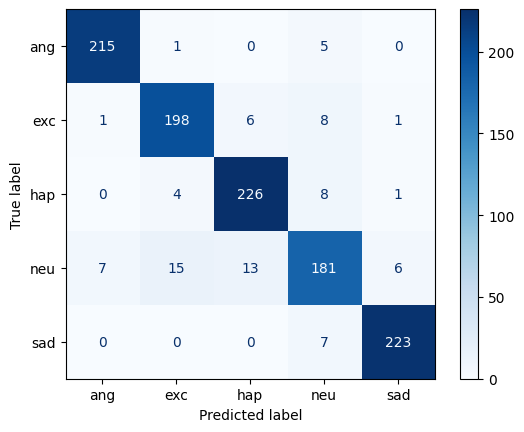

In [10]:
class_names = ["ang", "exc", "hap", "neu", "sad"]

y_pred_prob = model_combined.predict([X_mfccs_val, X_text_val])
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(true_classes, predicted_classes, digits=4)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0     0.9641    0.9729    0.9685       221
           1     0.9083    0.9252    0.9167       214
           2     0.9224    0.9456    0.9339       239
           3     0.8660    0.8153    0.8399       222
           4     0.9654    0.9696    0.9675       230

    accuracy                         0.9263      1126
   macro avg     0.9252    0.9257    0.9253      1126
weighted avg     0.9256    0.9263    0.9257      1126

